In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install evaluate
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0


In [3]:
!pip install accelerate==0.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 3.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate

In [5]:
main_data = pd.read_csv("/content/drive/MyDrive/Analysis/training.csv",names=['id','name', 'label', 'sentence'])
main_data.drop(index=0)

,id,name,label,sentence
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [6]:
percent = (main_data.isnull().sum() / main_data.shape[0]) * 100
new_train = pd.DataFrame(data=percent, columns=['Percentofnullvalues'])
new_train = new_train.sort_values(by='Percentofnullvalues', ascending=False)
print(new_train.head(15))

          Percentofnullvalues
sentence             0.918561
id                   0.000000
name                 0.000000
label                0.000000


In [7]:
main_data.isna().sum()

id            0
name          0
label         0
sentence    686
dtype: int64

In [8]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   name      74682 non-null  object
 2   label     74682 non-null  object
 3   sentence  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
def remove_columns(data):
    ''' Computing percent of null values in a dataset based on the feature and removing those features having 70 or more than 70 percent of null values '''
    columns_to_be_removed = []
    percent = (data.isnull().sum()/data.shape[0]) * 100
    for col in data.columns:
        if percent.loc[col] >= 80:
            columns_to_be_removed.append(col)
    new_data = data.drop(columns=columns_to_be_removed)
    return new_data

main_data = remove_columns(main_data)


In [10]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   name      74682 non-null  object
 2   label     74682 non-null  object
 3   sentence  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


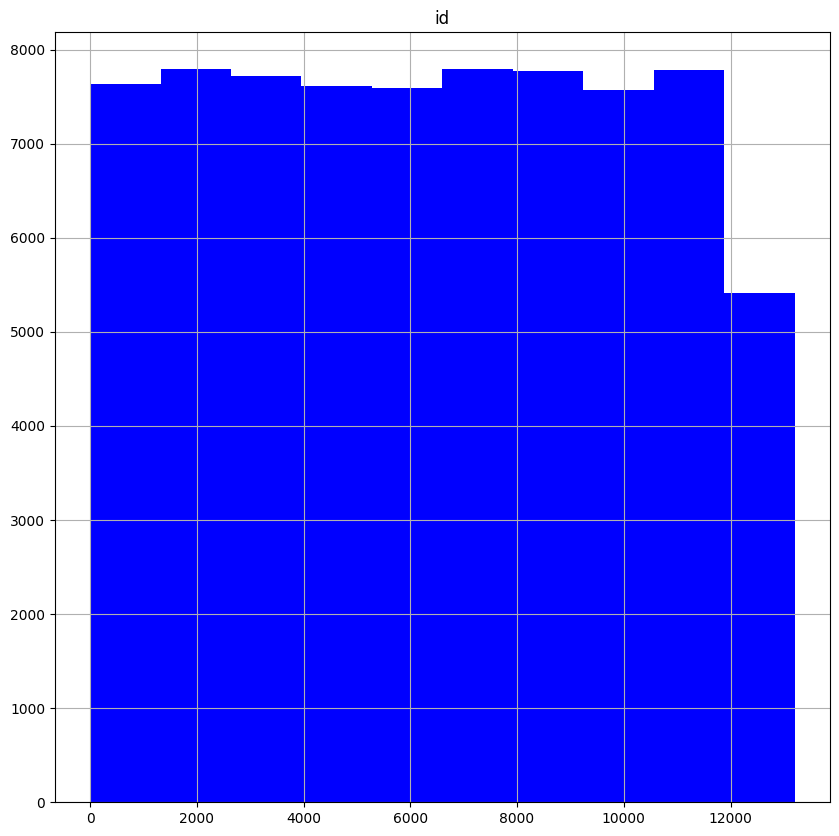

In [11]:
import matplotlib.pyplot as plt
main_data.hist(figsize=(10, 10), color='blue', label='Histogram')
plt.show()

In [12]:
main_data = main_data.dropna()
main_data  = main_data.iloc[:6000,:]
main_data.head(10)

,id,name,label,sentence
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [13]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 6061
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6000 non-null   int64 
 1   name      6000 non-null   object
 2   label     6000 non-null   object
 3   sentence  6000 non-null   object
dtypes: int64(1), object(3)
memory usage: 234.4+ KB


In [14]:
print("\nSummary Statistics:")
print(main_data.describe())


Summary Statistics:
                id
count  6000.000000
mean   1719.523667
std     945.692182
min       1.000000
25%    1622.000000
50%    1879.000000
75%    2538.000000
max    2800.000000


In [15]:
def encoder(data):
    values_list = list(data.unique())
    temp_dict = {}
    for item in values_list:
        index = values_list.index(item)
        temp_dict.update({item:index})
    print(temp_dict)
    for d in data.index:
        data[d] = temp_dict[data[d]]
    return data, temp_dict

print(main_data['label'].value_counts())
classes = main_data["label"].unique()

main_data['label'], label_map = encoder(main_data['label'])

Positive      2052
Neutral       1743
Negative      1291
Irrelevant     914
Name: label, dtype: int64
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


<ipython-input-15-f4557147845f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[d] = temp_dict[data[d]]


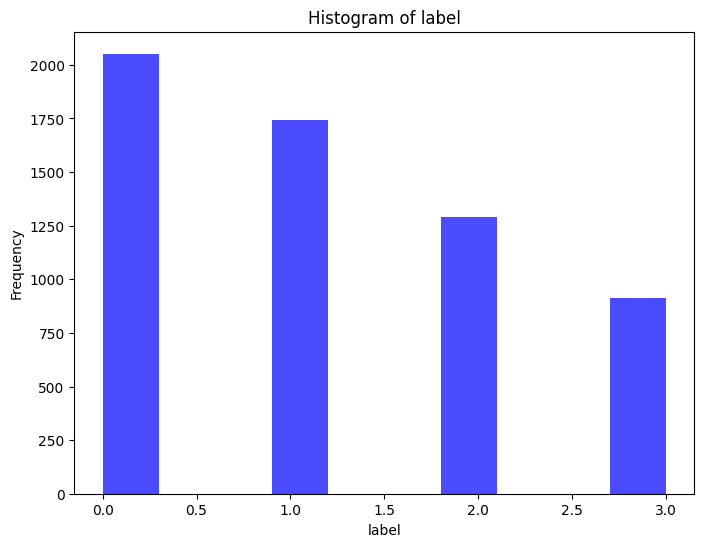

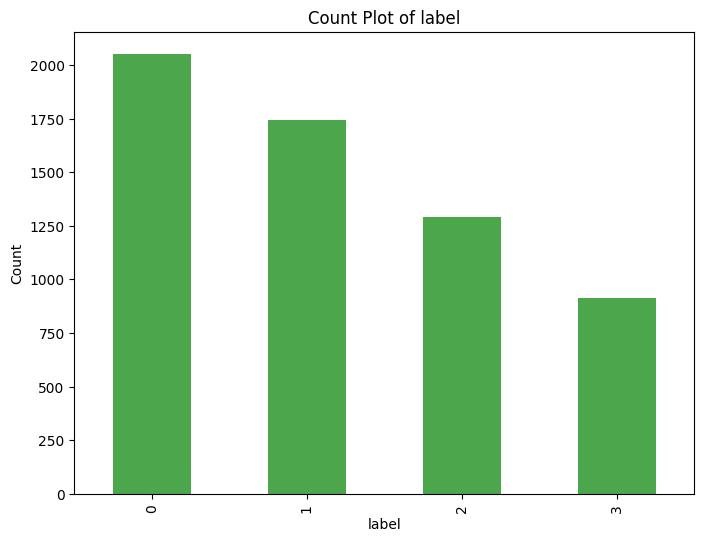

In [16]:
numeric_column = 'label'
plt.figure(figsize=(8, 6))
plt.hist(main_data[numeric_column], bins=10, color='blue', alpha=0.7)
plt.title(f'Histogram of {numeric_column}')
plt.xlabel(numeric_column)
plt.ylabel('Frequency')
plt.show()


categorical_column = 'label'
plt.figure(figsize=(8, 6))
main_data[categorical_column].value_counts().plot(kind='bar', color='green', alpha=0.7)
plt.title(f'Count Plot of {categorical_column}')
plt.xlabel(categorical_column)
plt.ylabel('Count')
plt.show()

In [17]:
train_data = main_data.sample(frac=0.8, random_state=42)
test_data = main_data.drop(train_data.index)
hg_train_data = Dataset.from_pandas(train_data)
hg_test_data = Dataset.from_pandas(test_data)
print(f'The length of train_data is {len(hg_train_data)}')
print(f'The length of test_data is {len(hg_test_data)}')

The length of train_data is 4800
The length of test_data is 1200


In [18]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [19]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["sentence"],
                     truncation=True,
                     padding="max_length")

dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [20]:
# Load model
# model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", num_labels=len(classes), ignore_mismatched_sizes=True).to(device=device)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", num_labels=len(classes), ignore_mismatched_sizes=True).to(device=device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/data/dataset/CA/",
    logging_dir='/content/drive/MyDrive/data/dataset/CA/logs',
    logging_strategy='epoch',
    logging_steps=10,
    num_train_epochs=50,
    per_device_train_batch_size=35,
    per_device_eval_batch_size=20,
    learning_rate=5e-6,
    seed=42,
    # save_strategy='epoch',
    # save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    # load_best_model_at_end=True,
)

In [22]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.284300,1.134338,0.549167
2,1.060700,0.993884,0.598333
3,0.912300,0.886757,0.655000
4,0.787400,0.805873,0.693333
5,0.671500,0.734358,0.727500
6,0.570800,0.669877,0.751667
7,0.491600,0.597649,0.775833
8,0.416600,0.541153,0.801667
9,0.338300,0.495734,0.825000
10,0.284300,0.445331,0.849167


Epoch,Training Loss,Validation Loss,Accuracy
1,1.284300,1.134338,0.549167
2,1.060700,0.993884,0.598333
3,0.912300,0.886757,0.655000
4,0.787400,0.805873,0.693333
5,0.671500,0.734358,0.727500
6,0.570800,0.669877,0.751667
7,0.491600,0.597649,0.775833
8,0.416600,0.541153,0.801667
9,0.338300,0.495734,0.825000
10,0.284300,0.445331,0.849167


TrainOutput(global_step=6900, training_loss=0.1806120290963546, metrics={'train_runtime': 11536.4664, 'train_samples_per_second': 20.804, 'train_steps_per_second': 0.598, 'total_flos': 3.179330961408e+16, 'train_loss': 0.1806120290963546, 'epoch': 50.0})

In [24]:
# Trainer evaluate
trainer.evaluate(dataset_test)

{'eval_loss': 0.3637281060218811,
 'eval_accuracy': 0.9233333333333333,
 'eval_runtime': 22.3692,
 'eval_samples_per_second': 53.645,
 'eval_steps_per_second': 2.682,
 'epoch': 50.0}

In [25]:
from scipy.special import softmax
y_test_predict = trainer.predict(dataset_test)
y_test_logits = y_test_predict.predictions
y_test_probabilities = softmax(y_test_logits, axis=1)
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)
y_test_actual_labels = y_test_predict.label_ids
metric_f1 = evaluate.load("f1")
f1_score = metric_f1.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='micro')
metric_recall = evaluate.load("recall")
recall_score = metric_recall.compute(predictions=y_test_pred_labels, references=y_test_actual_labels, average='micro')

print(f"""
        Recall Score ----> {list(recall_score.values())[0]}
        F1 Score --------> {list(f1_score.values())[0]}

    """)


        Recall Score ----> 0.9233333333333333
        F1 Score --------> 0.9233333333333333

    


In [26]:
folder_name = "analysis"
tokenizer.save_pretrained('./'+folder_name+'/')
trainer.save_model('./'+folder_name+'/')

### Get Prediction

In [27]:
folder_name = "analysis"
tokenizer = AutoTokenizer.from_pretrained('./'+folder_name+'/')
loaded_model = AutoModelForSequenceClassification.from_pretrained('./'+folder_name+'/')

In [28]:
input_text = "This is good. I can afford it"


# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Make predictions
with torch.no_grad():
    outputs = loaded_model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
# Interpret the prediction
sentiment_classes = classes
predicted_sentiment = sentiment_classes[predicted_class]
print(f"The predicted sentiment of the text is: {predicted_sentiment}")

The predicted sentiment of the text is: Positive
